In [1]:
#Notations : p prime, MesF Mestre test function, fnu inertia degree, lam = lambda

#MesF : Mestre test function. For these algorithms to be correct, MesF must be 
# Complactly supported in [-1,1], even function, positive Fourier transform

Mes(x) = (1-x)*cos(pi*x)+sin(pi*x)/pi


def liste_premier_lambda(lam):                         # Input : lam 
    C = floor(exp(lam))                                # Output : List of primes <= exp(lam)
    return prime_range(C+1)


#Only over Q
def Mestre_somme_premier_lambda(p,lam,MesF):            #Local Mestre sum          
    S,m,x = 0,1,p                                       
    while x<= exp(lam):
        S += (floor(2*sqrt(x)) * x^(-1) * MesF(m*math.log(p)/lam.numerical_approx())).numerical_approx()
        x *= x
        m += 1
    return numerical_approx(log(p)*S)


   
#Only works over Q.    
def Mestre_somme_lambda(lam,MesF):                        # Global Mestre sum 
    Liste = liste_premier_lambda(lam)
    Somme = 0
    for p in Liste:
        Somme += (Mestre_somme_premier_lambda(p,lam,MesF)).numerical_approx()
    return 2*Somme                                        #In the final formula this sum must be multiplied by two

#Only work over Q                                           
def somme_mult_badprimes_lambda(p,lam,MesF):                 # Local sum in the case of p|N i.e multiplicative reduction      
    S = p^(-1)*MesF(math.log(p)/lam.numerical_approx())
    m = 2
    x = p^2
    while x <= exp(lam):
        S= (S + x^(-1)*MesF(m*math.log(p)/lam.numerical_approx())).numerical_approx()
        x= p * x
        m = m+1
    return numerical_approx(log(p)*S)

                                                              #Additive reduciton : the sum is 0 we don't code it


#Only over Q - uses the Wil bound
#input : lambda, MesF,two lists of bad primes : one for multiplicative red and one for additive red



def Mestre_somme_withbadprimes_lambda(lam,MesF,mult_badprimes,add_badprimes): #Global sum with mult and add reductions
    Liste = liste_premier_lambda(lam)                                              
    Somme = 0
    for p in Liste:                                                  
        if p in mult_badprimes :                               #Correct sum for multiplicative red
            Somme += somme_mult_badprimes_lambda(p,lam,MesF)
        elif p in add_badprimes:
            Somme += 0                                         #Do nothing for additive reduction
        else:
            Somme += Mestre_somme_premier_lambda(p,lam,MesF)   # In case of good reduction
    return 2*Somme                                             #factor 2 in the final sum - present in Mestre explicit formula                                                           




#remark : the list we give in input are lists of primes CONTAINED in the set of primes of bad reduction.
#The algorithm stays worect if we forgot some primes of bad reduction, but the result is lee precise 
# that is to say the final bound is lwoer that it would be



#Function defining the integrals terms appearing. Not correct if MesF is not completly supported in [-1,1]


def Value_Phi_0(MesF):      #The integral term which will be multiplied by the rank. Fourier transform of MesF eval at 0
    return 2*numerical_integral(MesF(x),0,1)[0]


Constant_Mlambda = 2*math.log(2*pi)     #constant appearing in the formula, let's stock it



def Mlambda2(lam,MesF):
    aux(x) = MesF(x) * exp(-lam*x)/(1-exp(-lam*x)) - MesF(0) * exp(-lam*x)/(lam*x)
    a = numerical_integral(aux(x),0,1)[0]
    b = numerical_integral(exp(-x)/x, lam.numerical_approx() , Infinity )[0] #depends on lam, cannot be stocked :(
    return 2*(lam*a - MesF(0)*b) +   MesF(0)*Constant_Mlambda       #still a foctor two at the end, like the sum




#Final lower bound 

#Only over Q
def minorant_conducteur_lambda(lam,MesF,rk):      #Without knowing anything on the conductor
    K = lam * rk * Value_Phi_0(MesF)+Mlambda2(lam,MesF)-Mestre_somme_lambda(lam,MesF)
    return exp(K)

#Only over Q
def minorant_conducteur_lambda_withbadprimes(lam,MesF,rk,mult_badprimes,add_badprimes): #knowing some primes of add and mul reduction
    K = lam * rk *Value_Phi_0(MesF) + Mlambda2(lam,MesF)-Mestre_somme_withbadprimes_lambda(lam,MesF,mult_badprimes,add_badprimes)
    return exp(K)




In [2]:
#In number fields, without knowing anything about the bad primes, using only the Weil bound

def somme_premier_degre_ramifi(p,lam,MesF,fnu):
    q = p^fnu
    S,m,x = 0,1,q
    while x<= exp(lam):
        S += (floor(2*sqrt(x)) * x^(-1) * MesF(m*math.log(q)/lam.numerical_approx())).numerical_approx()
        x *=  q
        m +=  1
    return numerical_approx(log(q)*S)



def Mestre_somme_lambda_nbfield(lam,MesF,K):        #lam = lambda, MesF mestre test function, K number field            
    Liste = liste_premier_lambda(lam)
    Somme = 0
    for p in Liste:
        for pp in K.primes_above(p):
            fnu = pp.residue_class_degree()
            Somme += (somme_premier_degre_ramifi(p,lam,MesF,fnu)).numerical_approx()
    return 2 * Somme             # un facteur de 2 car deux termes conjugués dans la somme de Mestre



def minorant_conducteur_lambda_nbfield(lam,MesF,rk,K):     # K nb field (chose not to give polynomial in case of tower extension)  
    n = K.absolute_degree()
    disc = K.absolute_discriminant()
    lowbound = lam * rk * Value_Phi_0(MesF) + n * Mlambda2(lam,MesF) - Mestre_somme_lambda_nbfield(lam,MesF,K)
    return exp(lowbound)/(disc^2)




#With Frobenius

def Somme_Frob(p,fnu,lam,MesF,Frob):
    q = p^fnu 
    delt = Frob^2-4*q
    alpha = (Frob-I*sqrt(-delt))/2
    beta = (Frob+I*sqrt(-delt))/2
    a = alpha
    b = beta
    Somme = 0
    m = 1
    x = q
    while x <= exp(lam):
        Somme += (MesF(m*math.log(q)/numerical_approx(lam))*(a+b)/x).numerical_approx()   # compute the sum
        a     *= alpha                                             # powers of roots of Frob increment
        b     *= beta
        x     *= q                                                 # denominator of the sum increment
        m     += 1
    finalSomme = 2 * Somme * math.log(q)                           # factor  2 in the Mestre formula
    return numerical_approx(finalSomme)


def Mini_Somme_Frob(p,fnu,lam,MesF):       #take the minimal over all possible fors, return the frob and the sum 
    bound = floor(2*sqrt(p^fnu))
    MinFrob = - bound
    MinSomme = Somme_Frob(p,fnu,lam,MesF,MinFrob)
    for Frobenius in range(-bound+1,bound+1):
        C = Somme_Frob(p,fnu,lam,MesF,Frobenius)
        if C < MinSomme:
            MinFrob = Frobenius
            MinSomme = C
    return (MinFrob,MinSomme)


def Mestre_Somme_Frob(lam,MesF,K):
    Listeprime = liste_premier_lambda(lam)
    BigSomme = 0
    ListeFrob = []
    for p in Listeprime:
        for prims in K.primes_above(p):
            fnu = prims.residue_class_degree()
            frobenius,value = Mini_Somme_Frob(p,fnu,lam,MesF)
            BigSomme += value.numerical_approx()
            ListeFrob += [(p,fnu,frobenius)]
    return (ListeFrob,BigSomme)

def minorant_conducteur_nbfield_Frobenius(lam,MesF,rk,K):   # K nb field  
    n = K.absolute_degree()
    discri = K.absolute_discriminant()
    Listefrobs, MestreSomme = Mestre_Somme_Frob(lam,MesF,K)
    lowbound = lam * rk * Value_Phi_0(MesF) + n * Mlambda2(lam,MesF) + MestreSomme
    return Listefrobs , exp(lowbound)/(discri^2)





def Somme_liste_Frob(lam,MesF,lisfrobs):   #Input: the list of primes considered, with their fnu and attributed frobenius
    S = 0
    for k in lisfrobs:
        p,fnu,Frob = k
        S += (Somme_Frob(p,fnu,lam,MesF,Frob)).numerical_approx()
    return S

def minorant_liste_Frob(lam,MesF,rk,K,lisfrobs):
    n = K.absolute_degree()
    discri = K.absolute_discriminant()
    Mestresomme = Somme_liste_Frob(lam,MesF,lisfrobs)
    lowbound = lam * rk * Value_Phi_0(MesF) + n * Mlambda2(lam,MesF) + Mestresomme
    return  exp(lowbound)/(discri^2)
   

In [3]:
#   optimisation de la fonction de Mestre dans un sous espace de dimesion 5 


def fonctiontest(a0,a1,a2,a3,a4): #output convolution square of a0 + a1cos(2pix) + a2cos(4pix) + a3cos(6pix) +a4cos(pix)sur [-1/2,1/2]
    norm=sqrt(a0^2+1/2*(a1^2+a2^2+a3^2+a4^2) +2*(2/pi*a4*(a0+a1/3-a2/15+a3/35)))
    b0,b1,b2,b3,b4=a0/norm,a1/norm,a2/norm,a3/norm,a4/norm
    aux(x)=b0^2*g00(x)+b1^2*g11(x)+b2^2*g22(x)+b3^2*g33(x)+b4^2/2*Mes(x)+2*(b0*b1*g01(x)+b0*b2*g02(x)+b0*b3*g03(x)+b1*b2*g12(x)+b1*b3*g13(x)+b2*b3*g23(x)+b0*b4*gm0(x)+b1*b4*gm1(x)+b2*b4*gm2(x)+b3*b4*gm3(x))
    return aux

g00(x)= -x + 1
g01(x)= 1/2*sin(2*pi*x)/pi
g02(x)= -1/4*sin(4*pi*x)/pi
g03(x)= 1/6*sin(6*pi*x)/pi

g11(x)= 1/8*(2*pi*cos(2*pi*x) - sin(2*pi*x))/pi + 1/8*(2*(pi - 2*pi*x)*cos(2*pi*x) - sin(2*pi*x))/pi 
g12(x)= 1/3*sin(4*pi*x)/pi - 1/6*sin(2*pi*x)/pi
g13(x)= -3/16*sin(6*pi*x)/pi + 1/16*sin(2*pi*x)/pi

g22(x)= 1/16*(4*pi*cos(4*pi*x) - sin(4*pi*x))/pi + 1/16*(4*(pi - 2*pi*x)*cos(4*pi*x) - sin(4*pi*x))/pi
g23(x)= 3/10*sin(6*pi*x)/pi - 1/5*sin(4*pi*x)/pi

g33(x)= 1/24*(6*pi*cos(6*pi*x) - sin(6*pi*x))/pi + 1/24*(6*(pi - 2*pi*x)*cos(6*pi*x) - sin(6*pi*x))/pi

gm0(x) = cos(pi*x)/pi + 1/pi
gm1(x) = (1/6)*(sin(3/2*pi + 2*pi*x) + 3*sin(1/2*pi + 2*pi*x))/pi + 1/3*cos(pi*x)/pi
gm2(x) = (1/30)*(3*sin(5/2*pi + 4*pi*x) + 5*sin(3/2*pi + 4*pi*x))/pi - (1/15)*cos(pi*x)/pi
gm3(x) = (1/70)*(5*sin(7/2*pi + 6*pi*x) + 7*sin(5/2*pi + 6*pi*x))/pi + (1/35)*cos(pi*x)/pi

a00=1.27323954473516/2
a11=0.424413181578388
a22=-0.0848826363156775
a33=0.0363782727067189
b00=a00/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b11=a11/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b22=a22/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b33=a33/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))

def optimisitionfonction(lam,rk,K,lisfrobs,a0,a1,a2,a3,m0,pas,nb_iteration): #important condition : a0²+1/2(a1²+a2²+a3²+m0² 
    discri = K.absolute_discriminant()  #Notice I need to know the frobeniuses         + 2/pi(a0b0+a1b0/3 -a2b0/15 +a3b0/35)
    C00 = math.log(discri^2*minorant_liste_Frob(lam,g00,rk,K,lisfrobs))     #coefficient de ma fonction en a0,a1,a2,a3
    C01 = math.log(discri^2*minorant_liste_Frob(lam,g01,rk,K,lisfrobs)) 
    C02 = math.log(discri^2*minorant_liste_Frob(lam,g02,rk,K,lisfrobs)) 
    C03 = math.log(discri^2*minorant_liste_Frob(lam,g03,rk,K,lisfrobs)) 
    C11 = math.log(discri^2*minorant_liste_Frob(lam,g11,rk,K,lisfrobs)) 
    C12 = math.log(discri^2*minorant_liste_Frob(lam,g12,rk,K,lisfrobs)) 
    C13 = math.log(discri^2*minorant_liste_Frob(lam,g13,rk,K,lisfrobs)) 
    C22 = math.log(discri^2*minorant_liste_Frob(lam,g22,rk,K,lisfrobs)) 
    C23 = math.log(discri^2*minorant_liste_Frob(lam,g23,rk,K,lisfrobs)) 
    C33 = math.log(discri^2*minorant_liste_Frob(lam,g33,rk,K,lisfrobs))
    GM0 = math.log(discri^2*minorant_liste_Frob(lam,gm0,rk,K,lisfrobs))
    GM1 = math.log(discri^2*minorant_liste_Frob(lam,gm1,rk,K,lisfrobs))
    GM2 = math.log(discri^2*minorant_liste_Frob(lam,gm2,rk,K,lisfrobs))
    GM3 = math.log(discri^2*minorant_liste_Frob(lam,gm3,rk,K,lisfrobs))
    GG  = math.log(discri^2*minorant_liste_Frob(lam,Mes,rk,K,lisfrobs))
    b0 = a0
    b1 = a1
    b2 = a2
    b3 = a3
    b4 = m0
    for i in range(nb_iteration):
        tempvalue = (b0^2*C00+b1^2*C11+b2^2*C22+b3^2*C33+b4^2/2*GG+2*(b0*b1*C01+b0*b2*C02+b0*b3*C03+b1*b2*C12+b1*b3*C13+b2*b3*C23+b0*b4*GM0 +b1*b4*GM1 +b2*b4*GM2 +b3*b4*GM3)).numerical_approx() 
        gradient0 = ((2*b0*C00+2*b1*C01+2*b2*C02+2*b3*C03+2*b4*GM0) -tempvalue*(2*b0 + 2/pi*b4)).numerical_approx()    #gradient of the function
        gradient1 = ((2*b0*C01+2*b1*C11+2*b2*C12+2*b3*C13+2*b4*GM1)  -tempvalue*(b1  + 2/(3*pi)*b4)).numerical_approx()      
        gradient2 = ((2*b0*C02+2*b1*C12+2*b2*C22+2*b3*C23+2*b4*GM2)  -tempvalue*(b2  - 2/(15*pi)*b4)).numerical_approx()     
        gradient3 = ((2*b0*C03+2*b1*C13+2*b2*C23+2*b3*C33+2*b4*GM3)  -tempvalue*(b3  + 2/(35*pi)*b4)).numerical_approx() 
        gradient4 = ((2*b4*GG+2*b0*GM0+2*b1*GM1+2*b2*GM2+2*b3*GM3)  -tempvalue*(2*b4 + 2/pi*b0 + 2/(3*pi)*b1 - 2/(15*pi)*b2 +2/(35*pi)*b3)).numerical_approx() 
        normgrad = sqrt(gradient0^2+gradient1^2+gradient2^2+gradient3^2+gradient4^2)
        c0=(b0+gradient0*pas/normgrad).numerical_approx()                               # We move the original coordinates in the direction of the gradient 
        c1=(b1+gradient1*pas/normgrad).numerical_approx()                                             
        c2=(b2+gradient2*pas/normgrad).numerical_approx() 
        c3=(b3+gradient3*pas/normgrad).numerical_approx() 
        c4=(b4+gradient4*pas/normgrad).numerical_approx() 
        norm=sqrt(c0^2+1/2*(c1^2+c2^2+c3^2+c4^2) +2*(2/pi*c4*(c0+c1/3-c2/15+c3/35))) #final renormalisation to have F(0)=1                                      
        b0=(c0/norm).numerical_approx()
        b1=(c1/norm).numerical_approx()
        b2=(c2/norm).numerical_approx()
        b3=(c3/norm).numerical_approx()
        b4=(c4/norm).numerical_approx()
    finavalue=b0^2*C00+b1^2*C11+b2^2*C22+b3^2*C33+b4^2/2*GG+2*(b0*b1*C01 + b0*b2*C02 + b0*b3*C03 + b1*b2*C12 + b1*b3*C13 + b2*b3*C23 + b0*b4*GM0 + b1*b4*GM1 + b2*b4*GM2 + b3*b4*GM3 )
    return (b0,b1,b2,b3,b4,(1/discri^2)*exp(finavalue))


# To find the best lambda with 0.01 precision:
def optimi_lam1(MesF,rk,K):
    earlylam = 1
    earlyval = minorant_conducteur_lambda_nbfield(earlylam,MesF,rk,K) 
    while minorant_conducteur_lambda_nbfield(earlylam + 1,MesF,rk,K) > earlyval:
        earlyval = minorant_conducteur_lambda_nbfield(earlylam + 1,MesF,rk,K)
        earlylam = earlylam + 1
    midlam = earlylam-0.9
    midval = minorant_conducteur_lambda_nbfield(midlam,MesF,rk,K)
    while minorant_conducteur_lambda_nbfield(midlam + 0.1,MesF,rk,K) > midval:
        midval = minorant_conducteur_lambda_nbfield(midlam + 0.1,MesF,rk,K)
        midlam = midlam + 0.1
    finlam = midlam-0.09
    finval = minorant_conducteur_lambda_nbfield(finlam,MesF,rk,K)
    while minorant_conducteur_lambda_nbfield(finlam+0.01,MesF,rk,K) > finval:
        finval = minorant_conducteur_lambda_nbfield(finlam+0.01,MesF,rk,K)
        finlam += 0.01
    return (finlam)

def optimi_lam(MesF,rk,K):
    midlam = 1
    midval = minorant_conducteur_nbfield_Frobenius(midlam,MesF,rk,K)[1] 
    while minorant_conducteur_nbfield_Frobenius(midlam + 0.1,MesF,rk,K)[1] > midval:
        midval = minorant_conducteur_nbfield_Frobenius(midlam + 0.1,MesF,rk,K)[1]
        midlam = midlam + 0.1
    finlam = midlam-0.09
    finval = minorant_conducteur_nbfield_Frobenius(finlam,MesF,rk,K)[1]
    while minorant_conducteur_nbfield_Frobenius(finlam+0.01,MesF,rk,K)[1] > finval:
        finval = minorant_conducteur_nbfield_Frobenius(finlam+0.01,MesF,rk,K)[1]
        finlam += 0.01
    return (finlam)
        

In [4]:
# Fields of deg 5, root discriminant from 4 to 7


# Number fields downloaded from the LMFDB on 09 January 2024.
# Search link: https://www.lmfdb.org/NumberField/?degree=5&rd=1-7
# Query "{'degree': 5, 'rd': {'$gte': 0.99999999995, '$lte': 7.00000000005}}" returned 166 fields, sorted by degree.

# Each entry in the following data list has the form:
#    [Label, Polynomial, Discriminant, Galois group, Class group]
# For more details, see the definitions at the bottom of the file.

# To create a list of fields, type "fields = make_data()"


columns = ["label", "coeffs", "disc", "galois_label", "class_group"]
data5 = [
["5.1.1609.1", [1, 1, -1, -1, 0, 1], 1609, "5T5", []],
["5.1.1649.1", [1, -1, 1, 0, -1, 1], 1649, "5T5", []],
["5.1.1777.1", [-1, 1, -2, 1, -1, 1], 1777, "5T5", []],
["5.1.2209.1", [1, 0, -1, 2, -2, 1], 2209, "5T2", []],
["5.1.2297.1", [-1, 0, -1, 1, -1, 1], 2297, "5T5", []],
["5.1.2617.1", [-1, 0, -2, 1, 0, 1], 2617, "5T5", []],
["5.1.2665.1", [-1, 2, -1, 1, -1, 1], 2665, "5T5", []],
["5.1.2869.1", [-1, -1, 0, 0, 0, 1], 2869, "5T5", []],
["5.1.3017.1", [1, 0, -1, 0, 0, 1], 3017, "5T5", []],
["5.1.3089.1", [-1, 2, 0, -1, 0, 1], 3089, "5T5", []],
["5.1.3233.1", [-1, 0, -1, 0, 0, 1], 3233, "5T5", []],
["5.1.3369.1", [-1, -1, -1, 1, 0, 1], 3369, "5T5", []],
["5.1.3857.1", [1, 0, -1, 1, -1, 1], 3857, "5T5", []],
["5.1.3889.1", [-1, 1, 0, 1, -1, 1], 3889, "5T5", []],
["5.1.4169.1", [-1, 2, -1, 2, 0, 1], 4169, "5T5", []],
["5.1.4261.1", [-1, -2, -2, 0, 0, 1], 4261, "5T5", []],
["5.1.4409.1", [-1, 1, 1, 0, -1, 1], 4409, "5T5", []],
["5.1.4417.1", [-1, 0, -1, 2, -2, 1], 4417, "5T5", []],
["5.1.4429.1", [1, 0, -1, 2, -1, 1], 4429, "5T5", []],
["5.1.4432.1", [1, -1, 2, 0, -1, 1], 4432, "5T5", []],
["5.1.4477.1", [-1, 1, 0, 1, 0, 1], 4477, "5T5", []],
["5.3.4511.1", [1, 0, -2, -1, 0, 1], -4511, "5T5", []],
["5.1.4549.1", [-1, 0, -2, 2, -1, 1], 4549, "5T5", []],
["5.1.4597.1", [-1, -1, -2, 1, 0, 1], 4597, "5T5", []],
["5.1.4757.1", [-1, 2, -1, 2, -1, 1], 4757, "5T5", []],
["5.1.4817.1", [-1, 2, -1, 2, -2, 1], 4817, "5T5", []],
["5.1.4897.1", [1, 0, 1, -1, -1, 1], 4897, "5T5", []],
["5.3.4903.1", [-1, -1, 2, -1, -1, 1], -4903, "5T5", []],
["5.1.5025.1", [1, 1, -1, 0, -1, 1], 5025, "5T5", []],
["5.1.5164.1", [1, 2, 0, -1, -1, 1], 5164, "5T5", []],
["5.1.5437.1", [-1, 0, -2, 2, -2, 1], 5437, "5T5", []],
["5.1.5501.1", [1, -1, 2, 0, -2, 1], 5501, "5T5", []],
["5.3.5519.1", [-1, 0, 3, -1, -1, 1], -5519, "5T5", []],
["5.1.5584.1", [1, 1, 0, 0, -1, 1], 5584, "5T5", []],
["5.1.5653.1", [-1, 2, 0, 0, -1, 1], 5653, "5T5", []],
["5.1.5753.1", [1, -1, 2, -1, -1, 1], 5753, "5T5", []],
["5.3.5783.1", [-1, -2, 2, 1, -2, 1], -5783, "5T5", []],
["5.1.5864.1", [1, -2, 2, 1, -1, 1], 5864, "5T5", []],
["5.1.5913.1", [1, 1, -1, 2, -1, 1], 5913, "5T5", []],
["5.1.6241.1", [-1, 3, -2, 1, -1, 1], 6241, "5T2", []],
["5.1.6449.1", [-1, 0, -3, 1, -1, 1], 6449, "5T5", []],
["5.1.6581.1", [-1, 0, -2, 0, 0, 1], 6581, "5T5", []],
["5.1.6757.1", [1, -2, 3, 0, -1, 1], 6757, "5T5", []],
["5.1.6793.1", [1, 1, 0, 1, -1, 1], 6793, "5T5", []],
["5.3.7031.1", [1, -1, -1, -1, 0, 1], -7031, "5T5", []],
["5.1.7096.1", [1, 1, -1, 0, 0, 1], 7096, "5T5", []],
["5.1.7177.1", [-1, 2, -1, 3, -1, 1], 7177, "5T5", []],
["5.1.7265.1", [1, -1, 2, 1, -1, 1], 7265, "5T5", []],
["5.1.7333.1", [-1, 3, -2, 2, -2, 1], 7333, "5T5", []],
["5.3.7367.1", [-1, -2, 3, 0, -2, 1], -7367, "5T5", []],
["5.1.7373.1", [-1, 1, 2, 0, -2, 1], 7373, "5T5", []],
["5.1.7376.1", [2, -2, 0, 2, -2, 1], 7376, "5T5", []],
["5.3.7463.1", [1, -2, 0, 1, -2, 1], -7463, "5T5", []],
["5.1.7672.1", [-1, -2, 0, 1, -1, 1], 7672, "5T5", []],
["5.1.7684.1", [-1, 0, -1, -1, 0, 1], 7684, "5T5", []],
["5.1.7717.1", [1, 2, 0, 0, -2, 1], 7717, "5T5", []],
["5.1.7909.1", [1, 1, -2, 2, -2, 1], 7909, "5T5", []],
["5.1.8073.1", [-1, 2, 1, -1, -1, 1], 8073, "5T5", []],
["5.1.8105.1", [-1, 4, -4, 3, -2, 1], 8105, "5T5", []],
["5.1.8249.1", [-1, -1, 0, 1, -1, 1], 8249, "5T5", []],
["5.1.8329.1", [-1, 1, -1, -1, 0, 1], 8329, "5T5", []],
["5.1.8357.1", [-1, 2, -2, 0, -1, 1], 8357, "5T5", []],
["5.3.8519.1", [1, -1, -1, 0, -1, 1], -8519, "5T5", []],
["5.1.8529.1", [-1, 0, -3, 2, -2, 1], 8529, "5T5", []],
["5.3.8647.1", [1, 2, -2, -3, 0, 1], -8647, "5T5", []],
["5.1.8705.1", [-1, 2, -1, -1, -1, 1], 8705, "5T5", []],
["5.1.8752.1", [-1, -1, -1, 1, -1, 1], 8752, "5T5", []],
["5.1.8945.1", [-1, -1, -2, 1, -1, 1], 8945, "5T5", []],
["5.1.8968.1", [2, 0, 1, 2, -1, 1], 8968, "5T5", []],
["5.1.9065.1", [-1, 2, -3, 1, -1, 1], 9065, "5T5", []],
["5.1.9137.1", [-1, 2, 0, 1, -2, 1], 9137, "5T5", []],
["5.1.9412.1", [1, 2, -1, 1, 0, 1], 9412, "5T5", []],
["5.1.9437.1", [-1, -1, 0, 1, -2, 1], 9437, "5T5", []],
["5.3.9439.1", [1, -2, 1, -1, -1, 1], -9439, "5T5", []],
["5.1.9489.1", [-1, 2, -1, -2, 0, 1], 9489, "5T5", []],
["5.1.9552.1", [-2, 0, 2, 0, -2, 1], 9552, "5T5", []],
["5.1.9584.1", [1, 1, -1, 1, -1, 1], 9584, "5T5", []],
["5.1.9664.1", [-1, 1, -3, 1, -1, 1], 9664, "5T5", []],
["5.1.9701.1", [1, 0, 2, -2, -1, 1], 9701, "5T5", []],
["5.3.9759.1", [-1, -2, 1, 0, -2, 1], -9759, "5T5", []],
["5.1.9808.1", [-1, 3, -2, 2, -1, 1], 9808, "5T5", []],
["5.1.9829.1", [1, 0, -2, 2, -1, 1], 9829, "5T5", []],
["5.1.10229.1", [-1, 2, 0, 2, 0, 1], 10229, "5T5", []],
["5.1.10277.1", [1, 0, -2, 4, -2, 1], 10277, "5T5", []],
["5.1.10329.1", [-1, -2, -3, 0, 0, 1], 10329, "5T5", []],
["5.1.10381.1", [1, 1, 0, 1, -2, 1], 10381, "5T5", []],
["5.3.10407.1", [-1, 3, 0, -3, -1, 1], -10407, "5T5", []],
["5.1.10449.1", [1, 0, -2, 1, 0, 1], 10449, "5T5", []],
["5.1.10492.1", [-2, 2, -3, 2, -1, 1], 10492, "5T5", []],
["5.1.10532.1", [-1, -2, -1, 1, 0, 1], 10532, "5T5", []],
["5.1.10589.1", [-1, 1, -4, 3, -2, 1], 10589, "5T5", []],
["5.1.10609.1", [1, 1, -3, 3, -2, 1], 10609, "5T2", []],
["5.1.10729.1", [-1, 2, 1, 0, -2, 1], 10729, "5T5", []],
["5.1.10825.1", [-1, 3, -1, -1, 0, 1], 10825, "5T5", []],
["5.1.10832.1", [-1, 1, 0, 2, -1, 1], 10832, "5T5", []],
["5.1.10933.1", [-1, -1, 0, 2, -2, 1], 10933, "5T5", []],
["5.3.11119.1", [1, -3, 1, 1, -2, 1], -11119, "5T5", []],
["5.3.11243.1", [1, -2, 0, 0, -1, 1], -11243, "5T5", []],
["5.1.11317.1", [-1, 2, 0, 0, 0, 1], 11317, "5T5", []],
["5.1.11332.1", [-2, 0, 2, -1, -1, 1], 11332, "5T5", []],
["5.1.11469.1", [-1, 1, 0, 3, 0, 1], 11469, "5T5", []],
["5.3.11551.1", [-1, -1, 3, -2, -1, 1], -11551, "5T5", []],
["5.1.11693.1", [1, 1, -2, 0, 0, 1], 11693, "5T5", []],
["5.1.11809.1", [-1, -2, 0, 1, -2, 1], 11809, "5T5", []],
["5.1.11876.1", [-2, 2, -2, 3, -1, 1], 11876, "5T5", []],
["5.1.11993.1", [-1, 0, -2, 3, -2, 1], 11993, "5T5", []],
["5.1.12184.1", [2, -4, 3, 0, -1, 1], 12184, "5T5", []],
["5.1.12205.1", [-1, 1, -2, 0, 0, 1], 12205, "5T5", []],
["5.1.12349.1", [2, -3, 2, 0, -1, 1], 12349, "5T5", []],
["5.1.12389.1", [-1, 2, -4, 2, -2, 1], 12389, "5T5", []],
["5.1.12440.1", [2, -2, 1, 1, -2, 1], 12440, "5T5", []],
["5.3.12447.1", [-1, -3, -1, 1, 0, 1], -12447, "5T5", []],
["5.1.12481.1", [1, 1, -2, 1, -1, 1], 12481, "5T5", []],
["5.1.12517.1", [-2, 3, -3, 2, -2, 1], 12517, "5T5", []],
["5.1.12533.1", [-1, 1, -4, 2, -2, 1], 12533, "5T5", []],
["5.1.12752.1", [-2, 2, -2, 2, -2, 1], 12752, "5T5", []],
["5.1.12772.1", [1, 2, -1, -1, 0, 1], 12772, "5T5", []],
["5.1.12785.1", [-1, -1, -3, -1, 0, 1], 12785, "5T5", []],
["5.1.12917.1", [-1, 3, 0, -2, 0, 1], 12917, "5T5", []],
["5.1.13033.1", [1, 1, -1, 1, 0, 1], 13033, "5T5", []],
["5.1.13069.1", [1, -2, 4, -2, -1, 1], 13069, "5T5", []],
["5.1.13116.1", [2, 0, -1, 1, -2, 1], 13116, "5T5", []],
["5.1.13164.1", [3, -3, 1, 2, -2, 1], 13164, "5T5", []],
["5.1.13169.1", [1, 0, -3, 4, -2, 1], 13169, "5T5", []],
["5.3.13219.1", [1, -1, -2, 0, 0, 1], -13219, "5T5", []],
["5.3.13523.1", [1, -3, -1, -1, -1, 1], -13523, "5T5", []],
["5.1.13648.1", [2, 0, 0, 2, -1, 1], 13648, "5T5", []],
["5.1.13676.1", [-2, 2, 3, -2, -1, 1], 13676, "5T5", []],
["5.1.13792.1", [2, -2, 3, 1, -1, 1], 13792, "5T5", []],
["5.3.13799.1", [1, -3, 2, -1, -1, 1], -13799, "5T5", []],
["5.3.13883.1", [2, 1, 0, -2, -1, 1], -13883, "5T5", []],
["5.1.13957.1", [-1, 3, 0, 0, -2, 1], 13957, "5T5", []],
["5.3.14103.1", [1, -2, -1, 2, -2, 1], -14103, "5T5", []],
["5.1.14161.1", [-1, 3, -1, 0, -1, 1], 14161, "5T2", []],
["5.1.14176.1", [2, -2, 1, 1, -1, 1], 14176, "5T5", []],
["5.1.14249.1", [-1, 2, -5, 4, -2, 1], 14249, "5T5", []],
["5.1.14357.1", [2, -1, 1, 1, -1, 1], 14357, "5T5", []],
["5.3.14631.1", [-1, 0, 3, -3, -1, 1], -14631, "5T5", []],
["5.5.14641.1", [-1, 3, 3, -4, -1, 1], 14641, "5T1", []],
["5.1.14789.1", [-1, 3, -2, 3, -2, 1], 14789, "5T5", []],
["5.3.14891.1", [-2, 1, 3, -3, -1, 1], -14891, "5T5", []],
["5.3.14911.1", [1, 3, -1, -2, -1, 1], -14911, "5T5", []],
["5.1.15077.1", [2, 3, 0, -2, -1, 1], 15077, "5T5", []],
["5.1.15329.1", [-1, 1, -1, -3, 0, 1], 15329, "5T5", []],
["5.1.15497.1", [1, -1, 3, -2, -1, 1], 15497, "5T5", []],
["5.1.15532.1", [-2, 4, -5, 3, -2, 1], 15532, "5T5", []],
["5.3.15536.1", [2, 0, 0, 0, -2, 1], -15536, "5T5", []],
["5.1.15541.1", [-1, 0, -3, 2, -1, 1], 15541, "5T5", []],
["5.1.15616.1", [2, -1, 0, 2, -2, 1], 15616, "5T5", []],
["5.1.15705.1", [-1, 2, 0, 1, 0, 1], 15705, "5T5", []],
["5.1.15757.1", [-2, 1, 1, 0, -2, 1], 15757, "5T5", []],
["5.1.15856.1", [2, -2, 0, 3, -2, 1], 15856, "5T5", []],
["5.3.15919.1", [1, 0, -3, -2, 0, 1], -15919, "5T5", []],
["5.1.15944.1", [-1, 2, 0, 1, -1, 1], 15944, "5T5", []],
["5.1.15952.1", [-1, 1, 2, 0, -1, 1], 15952, "5T5", []],
["5.1.16085.1", [1, 1, 0, 2, -2, 1], 16085, "5T5", []],
["5.1.16109.1", [-2, 1, -3, 2, -2, 1], 16109, "5T5", []],
["5.1.16129.1", [-1, 3, 1, -2, -1, 1], 16129, "5T2", []],
["5.1.16192.1", [-1, 1, 1, 1, -1, 1], 16192, "5T5", []],
["5.1.16328.1", [-2, 2, -1, 1, -2, 1], 16328, "5T5", []],
["5.1.16364.1", [-1, 1, -1, -2, 0, 1], 16364, "5T5", []],
["5.1.16612.1", [2, 0, 0, -1, -1, 1], 16612, "5T5", []],
["5.1.16664.1", [-1, -1, -1, 2, -2, 1], 16664, "5T5", []],
["5.1.16672.1", [-2, 6, -6, 5, -2, 1], 16672, "5T5", []],
["5.1.16757.1", [1, 0, 2, 0, -1, 1], 16757, "5T5", []],
["5.1.16757.2", [-1, -2, 0, 2, -2, 1], 16757, "5T5", []]
]

ZZx.<x> = ZZ[]


def create_record(row):
    out = {col: val for col, val in zip(columns, row)}
    poly = ZZx(out["coeffs"])
    out["poly"] = poly
    field.<a> = NumberField(poly)
    out["field"] = field
    return out

def make_data5():
    return [create_record(row) for row in data5]

fields5 = make_data5()

# Label --
#    Each (global) number field has a unique label of the form d.r.D.i where
#    <ul>
#    <li>\(d\) is the degree;
#    <li>\(r\) is the real signature;  the full signature is therefore \([r,(d-r)/2]\);
#    <li>\(D\) is the absolute value of the discriminant;
#    <li>\(i\) is the index, counting from 1.  This is in case there is more than one
#      field with the same signature and absolute value of the
#      discriminant: for example <a href="/NumberField/4.0.1008.1">4.0.1008.1</a> and <a href="/NumberField/4.0.1008.2">4.0.1008.2</a>.
#    </ul>
#    The discriminant portion of the label can take the form \(a_1\) e \(\epsilon_1\) _ \(a_2\) e \(\epsilon_2\) _ \(\cdots\) _ \(a_k\) e \(\epsilon_k\) to mean the absolute value of the
#    discriminant equals \(a_1^{\epsilon_1}a_2^{\epsilon_2}\cdots a_k^{\epsilon_k}\).  The separators are the letter e and the underscore symbol.


#Polynomial (coeffs) --
#    A **defining polynomial** of a number field $K$ is an irreducible polynomial $f\in\Q[x]$ such that $K\cong \mathbb{Q}(a)$, where $a$ is a root of $f(x)$. Equivalently, it is a polynomial $f\in \Q[x]$ such that $K \cong \Q[x]/(f)$.

#    A root \(a \in K\) of the defining polynomial is a generator of \(K\).

#    {# original author: john.jones #}


#Galois group (galois_label) --
#    Let $K$ be a finite degree $n$ separable extension of a field $F$, and $K^{gal}$ be its
#    Galois (or normal) closure.
#    The **Galois group** for $K/F$ is the automorphism group $\Aut(K^{gal}/F)$.

#    This automorphism group acts on the $n$ embeddings $K\hookrightarrow K^{gal}$ via composition.  As a result, we get an injection $\Aut(K^{gal}/F)\hookrightarrow S_n$, which is well-defined up to the labelling of the $n$ embeddings, which corresponds to being well-defined up to conjugation in $S_n$.

#    We use the notation $\Gal(K/F)$ for $\Aut(K/F)$ when $K=K^{gal}$.

#    There is a naming convention for Galois groups up to degree $47$.





#Class group (class_group) --
#    The **ideal class group** of a number field $K$ with ring of integers $O_K$ is the group of equivalence classes of ideals, given by the quotient of the multiplicative group of all fractional ideals of $O_K$ by the subgroup of principal fractional ideals.

#    Since $K$ is a number field, the ideal class group of $K$ is a finite abelian group, and so has the structure of a product of cyclic groups encoded by a finite list $[a_1,\dots,a_n]$, where the $a_i$ are positive integers with $a_i\mid a_{i+1}$ for $1\le i<n$.




In [6]:
Liste_lambda_discri  = []
Liste_lambda_bounds  = []
Liste_discri_bounds  = []
Liste_field_bounds   = []
for data in fields5:
    J = data['field']
    poly = J.absolute_polynomial()
    rootdisc = float(abs(J.absolute_discriminant())^(1/6))
    optlam = optimi_lam1(Mes,0,J)
    low_bound = minorant_conducteur_lambda_nbfield(optlam,Mes,0,J)^(1/6)
    Liste_field_bounds  += [(poly,low_bound)]
    Liste_discri_bounds += [(rootdisc,low_bound)]
    Liste_lambda_bounds += [(optlam,low_bound)]
    Liste_lambda_discri += [(rootdisc,optlam)]
    print(rootdisc)

3.4231506094394395
3.437189232310745
3.4802830894667776
3.6088260801386944
3.632398596494114
3.7122221160127435
3.723484373489127
3.7695405951977525
3.8012743781928604
3.816245612915861
3.845335913859551
3.871834944624159
3.9601193341605536
3.9655764231308965
4.011794227980122
4.026415498059376
4.049393826955095
4.050617486365924
4.052449517077171
4.052906878362383
4.059736525754471
4.064858865250227
4.070545898795228
4.077673204140842
4.10099140019339
4.109567401141469
4.1208646531716555
4.121705731884547
4.13862437266911
4.157488330923358
4.1933381846879065
4.201524891551424
4.203813098064236
4.212024625397893
4.220654775625002
4.233007737670441
4.236678726326335
4.2465117190389945
4.252405258256699
4.290840427026207
4.314350218413892
4.328944140168828
4.348027876565534
4.351880243217052
4.376929146388038
4.383647267405818
4.391947678552313
4.40087739647177
4.407716102344694
4.411115657896567
4.411714221692588
4.412013351385834
4.42064432132883
4.441040826821356
4.44219780004158
4.44

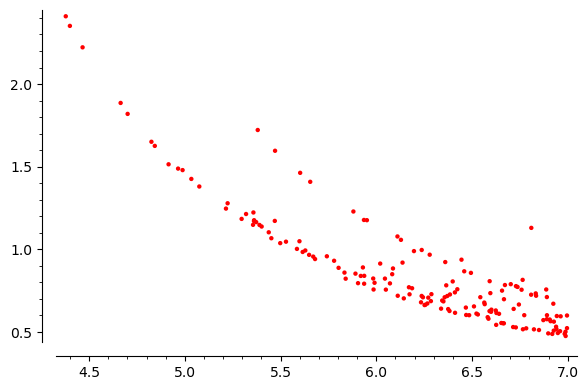

In [15]:
list_plot(Liste5_discri_bounds, color='red')
# x : the root discriminant
# y : the bound


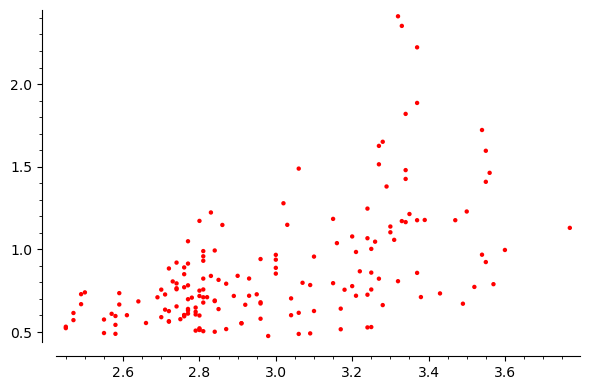

In [16]:
list_plot(Liste5_lambda_bounds, color='red')
# x : lambda
# y : the bound

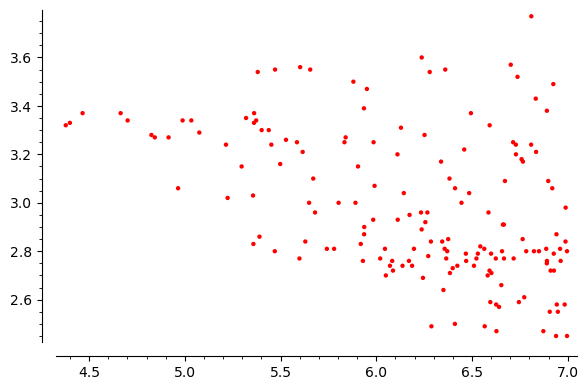

In [17]:
list_plot(Liste5_lambda_discri, color='red')
# x : root discriminant
# y : the optimal lambda for "the" field associated to this root discriminant